# **BASELINE - UNET**

# Architecture

Type info here

# Import Dependencies

In [38]:
# File Support
try: 
    import pydicom as dcm
except:
    # Use try except for Google Colab
    !pip install pydicom
from pydicom.data import get_testdata_files
import xml
import xml.etree.ElementTree as ET 

# Base
import numpy as np
import pandas as pd
import json
import random
import gc
from tqdm import tqdm

# Visualization
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.path import Path
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import seaborn as sns
from PIL import Image

# SK-learn
import sklearn
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV

# Files
import os
from os.path import join, split
from glob import glob

# Torch
import torch
from torch import nn
from torch.nn import Conv2d, MaxPool2d, ReLU, ConvTranspose2d
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
import torchvision
from torchvision.transforms import CenterCrop
import torch.nn.functional as F
from torch.optim import AdamW
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.checkpoint import checkpoint
from torch.autograd import Variable

import tempfile
import torch.multiprocessing as mp
import torch.distributed as dist
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.distributed.fsdp import CPUOffload, wrap
import bitsandbytes as bnb

In [39]:
torch.__version__

'2.2.2+cu121'

In [40]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:128"

In [41]:
torch.cuda.is_available()

True

# Config

In [42]:
len(os.listdir("Numpy Dataset\\all\images"))

7547

In [43]:
class CFG:
    random_seed = 42
    gated = True
    path = "Coronary CT Data\Gated_release_final" if gated else "Coronary CT Data/deidentified_nongated"
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    train_new = True
    model_num = len(os.listdir("Models")) if train_new else len(os.listdir("Models"))-1

    batch_size = 8
    nEpochs = 100
    lr = 0.1


In [44]:
import warnings
warnings.filterwarnings("ignore")

In [45]:
torch.cuda.empty_cache()
gc.collect()

9057

In [46]:
torch.cuda.memory_usage()

21

In [47]:
def setup(rank, world_size):
    os.environ['MASTER_ADDR'] = 'localhost'
    os.environ['MASTER_PORT'] = '12355'

    # initialize the process group
    dist.init_process_group("gloo", rank=rank, world_size=world_size)

def cleanup():
    dist.destroy_process_group()

## Reproducibility

In [48]:
def set_seed(seed=CFG.random_seed):
    print(f"Seed: {seed}")
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

set_seed()

Seed: 42


# Load Data

In [49]:
def parseXML(xmlfile): 
    # create element tree object 
    tree = ET.parse(xmlfile) 

    all_images = []

    images = tree.find("dict").find("array")
    images = images.findall("dict")

    # Images
    for image in images:
        image_data = {}
        arr = [i.text for i in image if i.tag not in ["array", "dict"]]
        
        for i in range(len(arr)//2):
            image_data[arr[2*i]] = arr[2*i+1]

        image_data['ROIs'] = []

        # ROI
        all_roi = image.find("array").findall('dict')
        for roi in all_roi:
            roi_data = {}
            arr = [i.text for i in roi if i.tag not in ["array", "dict"]]
        
            for i in range(len(arr)//2):
                roi_data[arr[2*i]] = arr[2*i+1]

            all_points = roi.findall('array')
            roi_data['point_mm'] = [i.text for i in all_points[0].findall("string")]
            roi_data['point_px'] = [i.text for i in all_points[1].findall("string")]
            
            image_data['ROIs'].append(roi_data)
        all_images.append(image_data)

    return all_images

In [50]:
def create_segments(image_array, points):
    polygon = Polygon(points, closed=True, edgecolor='r', facecolor='r')
    polygon_indices = np.array(points)
    polygon_indices[:, 0] = np.clip(polygon_indices[:, 0], 0, 511)
    polygon_indices[:, 1] = np.clip(polygon_indices[:, 1], 0, 511)
    image_array[polygon_indices[:, 1], polygon_indices[:, 0]] = 1
    polygon_path = Path(polygon_indices)
    x, y = np.meshgrid(np.arange(512), np.arange(512))
    points = np.column_stack((x.flatten(), y.flatten()))
    mask = polygon_path.contains_points(points).reshape(512, 512)
    image_array[mask] = 1

    return image_array

In [51]:
class CTDataset(Dataset):
    def __init__(self, dir):
        super().__init__()
        self.dir = dir
        self.images_path = join(dir, "images")
        self.labels_path = join(dir, "labels")
        self.images = os.listdir(self.images_path)
        self.labels = os.listdir(self.labels_path)

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx): # Return tuple (x, y)
        try:
            img = np.load(join(self.images_path, self.images[idx]), allow_pickle=True)
            img = img.reshape(1, 512, 512) # Hard coded since all images are 512, 512

            label = np.load(join(self.labels_path, self.labels[idx]), allow_pickle=True)
            label = label.reshape(1, 512, 512)
        except:
            img, label = np.zeros((1,512,512), np.float32),np.zeros((1,512,512), np.float32)
        return  img,label

In [52]:
train = CTDataset("Numpy Dataset\\train")
valid = CTDataset("Numpy Dataset\\valid")
test = CTDataset("Numpy Dataset\\test")

In [53]:
trainDL = DataLoader(train, batch_size=CFG.batch_size,shuffle=True, pin_memory=True)
validDL = DataLoader(valid, batch_size=CFG.batch_size)
testDL = DataLoader(test, batch_size=1)

In [54]:
print(f"Train: {len(train)}")
print(f"Valid: {len(valid)}")
print(f"Test: {len(test)}")

Train: 5331
Valid: 1598
Test: 616


# Model

In [55]:
class Block(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()

        self.conv1 = Conv2d(in_ch, out_ch, 3, padding=1)
        self.relu  = ReLU()
        self.conv2 = Conv2d(out_ch, out_ch, 3, padding=1)

        # init random weights
        nn.init.xavier_normal_(self.conv1.weight)
        nn.init.zeros_(self.conv1.bias)

        nn.init.xavier_normal_(self.conv2.weight)
        nn.init.zeros_(self.conv2.bias)
    
    def forward(self, x):
        return self.relu(self.conv2(self.relu(self.conv1(x))))

In [56]:
class AutoEncoder(nn.Module):
    def __init__(self, channels = (1,32,64,128,256,512,1024)):
        super().__init__()
        self.channels = channels
        self.pool = MaxPool2d((2,2))

        self.encoder = nn.ModuleList([
            Block(channels[i], channels[i+1]) for i in range(len(channels)-1) # 1, 32, ..., 1024
        ])

    def forward(self, x):
        skip_out = []
        for block in self.encoder: # Goes through all blocks, passes through block and saves skip output
            x = block(x)
            skip_out.append(x)
            x = self.pool(x) # Reduces dim
        return skip_out

In [57]:
class AutoDecoder(nn.Module):
    def __init__(self, channels = (1,32,64,128,256,512,1024)):
        super().__init__()
        self.channels = channels[:0:-1] # Reverse of Encoder (Excluding First Unneeded in Output)
        self.pool = MaxPool2d((2,2))
        self.upconv = nn.ModuleList([
            ConvTranspose2d(self.channels[i], self.channels[i+1], 2, 2) for i in range(len(self.channels)-1)
        ])

        self.decoder = nn.ModuleList([
            Block(self.channels[i], self.channels[i+1]) for i in range(len(self.channels)-1)
        ])

    def center_crop(self, x, enc_out): # Crop encoder output
        _, _, h, w = x.shape
        enc_out = CenterCrop([h,w])(enc_out)
        return enc_out
    
    def forward(self, x, enc_out:list):
        for i in range(len(self.channels)-1):
            x = self.upconv[i](x)
            enc_ftrs = self.center_crop(x, enc_out[i]) # Crop Skip
            x = torch.cat([x, enc_ftrs], dim=1) # Concatenate Decoder and Skip
            x = self.decoder[i](x)

            # Min Max Scaling [0,1]
            x = (x-x.min())/(x.max()-x.min())
        return x


In [58]:
class UNET(nn.Module):
    def __init__(self, channels = (1,32,64,128,256,512, 1024, 2048)):
        super().__init__()

        # Encoder Path
        self.enc_path = AutoEncoder(channels)

        # Decoder Path
        self.dec_path = AutoDecoder(channels)

        self.out = Conv2d(channels[1], 1, 1)

        # init random weights
        nn.init.xavier_normal_(self.out.weight)
        nn.init.zeros_(self.out.bias)

    
    def forward(self, x):
        skips = self.enc_path(x)
        x = self.dec_path(skips[::-1][0], skips[::-1][1:]) 
        # Reverse of enc_out = upward path of decoder 
        #  [0] -> 1024 output
        # [1:] -> All other skip outputs
        x = self.out(x)
        # x = F.interpolate(x, (512,512))
        x = F.sigmoid(x)

        return x

In [59]:
if not CFG.train_new:
    try:
        model = torch.load(f"Models/{CFG.model_name}/{CFG.model_name}.pt")
    except FileNotFoundError:
        print("Model not found in models folder")

# Train

## Dice Loss

Sørensen–Dice coefficient:
[Wikipedia](https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient)
</br>
$${\displaystyle DSC={\frac {2|X\cap Y|}{|X|+|Y|}}}

In [60]:
class diceCoef(nn.Module):
    def init(self):
        super(diceCoef, self).init()

    def forward(self, inputs, targets, smooth=1):        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice

In [61]:
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss
        
        return Dice_BCE

In [62]:
class IoULoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(IoULoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #intersection is equivalent to True Positive count
        #union is the mutually inclusive area of all labels & predictions 
        intersection = (inputs * targets).sum()
        total = (inputs + targets).sum()
        union = total - intersection 
        
        IoU = (intersection + smooth)/(union + smooth)
                
        return 1 - IoU

In [63]:
class TverskyLoss(nn.Module):
    def __init__(self, weight=None, size_average=True, ALPHA = 0.5, BETA = 0.5):
        super(TverskyLoss, self).__init__()
        self.alpha = ALPHA
        self.beta = BETA

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #True Positives, False Positives & False Negatives
        TP = (inputs * targets).sum()    
        FP = ((1-targets) * inputs).sum()
        FN = (targets * (1-inputs)).sum()
       
        Tversky = (TP + smooth) / (TP + self.alpha*FP + self.beta*FN + smooth)  
        
        return 1 - Tversky

In [64]:
criterion_dice_bce = DiceBCELoss()

In [65]:
criterion_dice = diceCoef()

In [66]:
criterion_iou = IoULoss()

In [67]:
criterion_bce = torch.nn.BCEWithLogitsLoss()

In [68]:
criterion_tversk = TverskyLoss()

* Pixel Binary
* IOU
* BCE Dice

## Training Loop

In [69]:
trainDL = DataLoader(train, batch_size=16, shuffle=True)
validDL = DataLoader(valid, batch_size=16, shuffle=False)

In [70]:
def train_epoch(model,  criterion, optim, scheduler):      
    train_loss = 0
    bce_loss = 0
    iou_loss = 0
    dice_loss = 0
    for x,y in tqdm(trainDL):
        x, y = x.to(CFG.device), y.to(CFG.device)
        optim.zero_grad()
        with torch.cuda.amp.autocast(dtype=torch.float16):
            pred = checkpoint(model, x).detach()
            loss = criterion(pred, y)
            loss = Variable(loss, requires_grad=True)
            
        loss.backward()
        optim.step()
        train_loss += loss
        del x,y,pred,loss
    
    
    # eval
    with torch.no_grad():
        for x,y in validDL:
            x, y = x.to(CFG.device), y.to(CFG.device)
            pred = model(x).detach()
            loss_bce = criterion_bce(pred, y)
            loss_dice = criterion_dice(pred,y)
            loss_iou = criterion_iou(pred, y)
            bce_loss += loss_bce
            iou_loss += loss_iou
            dice_loss += loss_dice
    
    scheduler.step(bce_loss)
        
    avg_train_loss = train_loss/len(trainDL)
    avg_bce_loss = bce_loss/len(validDL)
    avg_iou_loss = iou_loss/len(validDL)
    avg_dice_loss = dice_loss/len(validDL)

    
    print(f"Train Loss: {avg_train_loss}")
    print(f"Validation BCE Loss: {avg_bce_loss}")
    print(f"Validation Dice Loss: {avg_dice_loss}")
    print(f"Validation IOU Loss: {avg_iou_loss}")
    return avg_train_loss, avg_dice_loss

In [101]:
def run_model(criterion, model = None, init_lr = 0.1, name = "model", nEpochs = CFG.nEpochs):
    if not model:
        model = UNET().to(CFG.device)
    model.train()

    optim = AdamW(model.parameters(), lr=init_lr)
    scheduler = lr_scheduler.ReduceLROnPlateau(optim, factor=0.5, min_lr=0.0001, verbose=True)

    train_hist = []
    val_hist = []

    for e in range(nEpochs):
        print(f"\n\n[INFO] Epoch {e+1}/{nEpochs}")
        print(scheduler.optimizer.param_groups[0]['lr'])
        train_loss, val_loss = train_epoch(model, criterion, optim, scheduler)
        train_hist.append(float(train_loss.detach().cpu()))
        val_hist.append(float(val_loss.detach().cpu()))

    if not os.path.exists(f"Models/{name}"):
        os.mkdir(f"Models/{name}")
    torch.save(model.state_dict(), f"Models/{name}/model.pt")

    history = pd.DataFrame({"train":train_hist, 
                         'validation':val_hist}, index = range(1,len(train_hist)+1))
    
    history.to_csv(f"Models/{name}/logs.csv")

In [96]:
for i in range(200):
    # criterion = criterion_bce()
    run_model(criterion_bce, name=f"BCE3-{i}", nEpochs=2)

NotImplementedError: 

In [83]:
losses = {}
for i in glob("Models/**"):
    if os.path.exists(f"{i}\logs.csv"):
        try:
            file_loss = min(pd.read_csv(f"{i}\logs.csv")["validation"])
            losses[split(i)[-1]] = file_loss
        except:
            continue

In [84]:
for i in losses:
    if losses[i] == min(losses.values()):
        print(i)
        best = f"Models/{i}/model.pt"

BCE2-104


In [102]:
TRAIN = True
if TRAIN:
    model = UNET().to(CFG.device)
    model.load_state_dict(torch.load(best))
    run_model(model = model, criterion=criterion_bce, name="Fine Tuned UNET23 BCE")



[INFO] Epoch 1/100
0.1


100%|██████████| 334/334 [00:55<00:00,  6.03it/s]


Train Loss: 1.021493673324585
Validation BCE Loss: 1.0259528160095215
Validation Dice Loss: 0.9999650120735168
Validation IOU Loss: 0.9999831318855286


[INFO] Epoch 2/100
0.1


100%|██████████| 334/334 [00:54<00:00,  6.09it/s]


Train Loss: 1.0213531255722046
Validation BCE Loss: 1.0259528160095215
Validation Dice Loss: 0.9999650120735168
Validation IOU Loss: 0.9999831318855286


[INFO] Epoch 3/100
0.1


100%|██████████| 334/334 [00:54<00:00,  6.09it/s]


Train Loss: 1.0216952562332153
Validation BCE Loss: 1.0259528160095215
Validation Dice Loss: 0.9999650120735168
Validation IOU Loss: 0.9999831318855286


[INFO] Epoch 4/100
0.1


100%|██████████| 334/334 [00:55<00:00,  6.07it/s]


Train Loss: 1.0214214324951172
Validation BCE Loss: 1.0259528160095215
Validation Dice Loss: 0.9999650120735168
Validation IOU Loss: 0.9999831318855286


[INFO] Epoch 5/100
0.1


100%|██████████| 334/334 [00:55<00:00,  6.05it/s]


Train Loss: 1.0212551355361938
Validation BCE Loss: 1.0259528160095215
Validation Dice Loss: 0.9999650120735168
Validation IOU Loss: 0.9999831318855286


[INFO] Epoch 6/100
0.1


100%|██████████| 334/334 [00:55<00:00,  6.06it/s]


Train Loss: 1.0215409994125366
Validation BCE Loss: 1.0259528160095215
Validation Dice Loss: 0.9999650120735168
Validation IOU Loss: 0.9999831318855286


[INFO] Epoch 7/100
0.1


100%|██████████| 334/334 [00:54<00:00,  6.10it/s]


Train Loss: 1.021484136581421
Validation BCE Loss: 1.0259528160095215
Validation Dice Loss: 0.9999650120735168
Validation IOU Loss: 0.9999831318855286


[INFO] Epoch 8/100
0.1


100%|██████████| 334/334 [00:54<00:00,  6.10it/s]


Train Loss: 1.021565318107605
Validation BCE Loss: 1.0259528160095215
Validation Dice Loss: 0.9999650120735168
Validation IOU Loss: 0.9999831318855286


[INFO] Epoch 9/100
0.1


100%|██████████| 334/334 [00:55<00:00,  6.07it/s]


Train Loss: 1.0217386484146118
Validation BCE Loss: 1.0259528160095215
Validation Dice Loss: 0.9999650120735168
Validation IOU Loss: 0.9999831318855286


[INFO] Epoch 10/100
0.1


100%|██████████| 334/334 [00:54<00:00,  6.07it/s]


Train Loss: 1.021519660949707
Validation BCE Loss: 1.0259528160095215
Validation Dice Loss: 0.9999650120735168
Validation IOU Loss: 0.9999831318855286


[INFO] Epoch 11/100
0.1


100%|██████████| 334/334 [00:54<00:00,  6.10it/s]


Train Loss: 1.0215539932250977
Validation BCE Loss: 1.0259528160095215
Validation Dice Loss: 0.9999650120735168
Validation IOU Loss: 0.9999831318855286


[INFO] Epoch 12/100
0.1


100%|██████████| 334/334 [00:54<00:00,  6.10it/s]


Train Loss: 1.0215682983398438
Validation BCE Loss: 1.0259528160095215
Validation Dice Loss: 0.9999650120735168
Validation IOU Loss: 0.9999831318855286


[INFO] Epoch 13/100
0.05


100%|██████████| 334/334 [00:55<00:00,  6.06it/s]


Train Loss: 1.021691083908081
Validation BCE Loss: 1.0259528160095215
Validation Dice Loss: 0.9999650120735168
Validation IOU Loss: 0.9999831318855286


[INFO] Epoch 14/100
0.05


100%|██████████| 334/334 [00:55<00:00,  6.04it/s]


Train Loss: 1.021449089050293
Validation BCE Loss: 1.0259528160095215
Validation Dice Loss: 0.9999650120735168
Validation IOU Loss: 0.9999831318855286


[INFO] Epoch 15/100
0.05


100%|██████████| 334/334 [00:54<00:00,  6.08it/s]


Train Loss: 1.0216501951217651
Validation BCE Loss: 1.0259528160095215
Validation Dice Loss: 0.9999650120735168
Validation IOU Loss: 0.9999831318855286


[INFO] Epoch 16/100
0.05


100%|██████████| 334/334 [00:54<00:00,  6.08it/s]


Train Loss: 1.0217034816741943
Validation BCE Loss: 1.0259528160095215
Validation Dice Loss: 0.9999650120735168
Validation IOU Loss: 0.9999831318855286


[INFO] Epoch 17/100
0.05


100%|██████████| 334/334 [00:55<00:00,  6.07it/s]


Train Loss: 1.0214346647262573
Validation BCE Loss: 1.0259528160095215
Validation Dice Loss: 0.9999650120735168
Validation IOU Loss: 0.9999831318855286


[INFO] Epoch 18/100
0.05


100%|██████████| 334/334 [00:55<00:00,  6.02it/s]


Train Loss: 1.0217572450637817
Validation BCE Loss: 1.0259528160095215
Validation Dice Loss: 0.9999650120735168
Validation IOU Loss: 0.9999831318855286


[INFO] Epoch 19/100
0.05


100%|██████████| 334/334 [00:54<00:00,  6.07it/s]


Train Loss: 1.0214442014694214
Validation BCE Loss: 1.0259528160095215
Validation Dice Loss: 0.9999650120735168
Validation IOU Loss: 0.9999831318855286


[INFO] Epoch 20/100
0.05


100%|██████████| 334/334 [00:54<00:00,  6.09it/s]


Train Loss: 1.0216313600540161
Validation BCE Loss: 1.0259528160095215
Validation Dice Loss: 0.9999650120735168
Validation IOU Loss: 0.9999831318855286


[INFO] Epoch 21/100
0.05


100%|██████████| 334/334 [00:55<00:00,  6.03it/s]


Train Loss: 1.0216155052185059
Validation BCE Loss: 1.0259528160095215
Validation Dice Loss: 0.9999650120735168
Validation IOU Loss: 0.9999831318855286


[INFO] Epoch 22/100
0.05


100%|██████████| 334/334 [00:55<00:00,  6.07it/s]


Train Loss: 1.0219138860702515
Validation BCE Loss: 1.0259528160095215
Validation Dice Loss: 0.9999650120735168
Validation IOU Loss: 0.9999831318855286


[INFO] Epoch 23/100
0.05


100%|██████████| 334/334 [00:55<00:00,  6.07it/s]


Train Loss: 1.021393895149231
Validation BCE Loss: 1.0259528160095215
Validation Dice Loss: 0.9999650120735168
Validation IOU Loss: 0.9999831318855286


[INFO] Epoch 24/100
0.025


100%|██████████| 334/334 [00:55<00:00,  6.07it/s]


Train Loss: 1.0214017629623413
Validation BCE Loss: 1.0259528160095215
Validation Dice Loss: 0.9999650120735168
Validation IOU Loss: 0.9999831318855286


[INFO] Epoch 25/100
0.025


100%|██████████| 334/334 [00:54<00:00,  6.08it/s]


Train Loss: 1.021389126777649
Validation BCE Loss: 1.0259528160095215
Validation Dice Loss: 0.9999650120735168
Validation IOU Loss: 0.9999831318855286


[INFO] Epoch 26/100
0.025


100%|██████████| 334/334 [00:54<00:00,  6.10it/s]


Train Loss: 1.0216028690338135
Validation BCE Loss: 1.0259528160095215
Validation Dice Loss: 0.9999650120735168
Validation IOU Loss: 0.9999831318855286


[INFO] Epoch 27/100
0.025


100%|██████████| 334/334 [00:54<00:00,  6.09it/s]


Train Loss: 1.0215421915054321
Validation BCE Loss: 1.0259528160095215
Validation Dice Loss: 0.9999650120735168
Validation IOU Loss: 0.9999831318855286


[INFO] Epoch 28/100
0.025


100%|██████████| 334/334 [00:54<00:00,  6.10it/s]


Train Loss: 1.0215821266174316
Validation BCE Loss: 1.0259528160095215
Validation Dice Loss: 0.9999650120735168
Validation IOU Loss: 0.9999831318855286


[INFO] Epoch 29/100
0.025


100%|██████████| 334/334 [00:53<00:00,  6.29it/s]


Train Loss: 1.021653413772583
Validation BCE Loss: 1.0259528160095215
Validation Dice Loss: 0.9999650120735168
Validation IOU Loss: 0.9999831318855286


[INFO] Epoch 30/100
0.025


100%|██████████| 334/334 [00:53<00:00,  6.29it/s]


Train Loss: 1.0218799114227295
Validation BCE Loss: 1.0259528160095215
Validation Dice Loss: 0.9999650120735168
Validation IOU Loss: 0.9999831318855286


[INFO] Epoch 31/100
0.025


100%|██████████| 334/334 [00:53<00:00,  6.29it/s]


Train Loss: 1.0215299129486084
Validation BCE Loss: 1.0259528160095215
Validation Dice Loss: 0.9999650120735168
Validation IOU Loss: 0.9999831318855286


[INFO] Epoch 32/100
0.025


100%|██████████| 334/334 [00:53<00:00,  6.29it/s]


Train Loss: 1.0216243267059326
Validation BCE Loss: 1.0259528160095215
Validation Dice Loss: 0.9999650120735168
Validation IOU Loss: 0.9999831318855286


[INFO] Epoch 33/100
0.025


100%|██████████| 334/334 [00:53<00:00,  6.29it/s]


Train Loss: 1.021558165550232
Validation BCE Loss: 1.0259528160095215
Validation Dice Loss: 0.9999650120735168
Validation IOU Loss: 0.9999831318855286


[INFO] Epoch 34/100
0.025


100%|██████████| 334/334 [00:53<00:00,  6.29it/s]


Train Loss: 1.0214362144470215
Validation BCE Loss: 1.0259528160095215
Validation Dice Loss: 0.9999650120735168
Validation IOU Loss: 0.9999831318855286


[INFO] Epoch 35/100
0.0125


100%|██████████| 334/334 [00:53<00:00,  6.29it/s]


Train Loss: 1.0214811563491821
Validation BCE Loss: 1.0259528160095215
Validation Dice Loss: 0.9999650120735168
Validation IOU Loss: 0.9999831318855286


[INFO] Epoch 36/100
0.0125


100%|██████████| 334/334 [00:53<00:00,  6.29it/s]


Train Loss: 1.0217067003250122
Validation BCE Loss: 1.0259528160095215
Validation Dice Loss: 0.9999650120735168
Validation IOU Loss: 0.9999831318855286


[INFO] Epoch 37/100
0.0125


100%|██████████| 334/334 [00:53<00:00,  6.29it/s]


Train Loss: 1.0214288234710693
Validation BCE Loss: 1.0259528160095215
Validation Dice Loss: 0.9999650120735168
Validation IOU Loss: 0.9999831318855286


[INFO] Epoch 38/100
0.0125


100%|██████████| 334/334 [00:53<00:00,  6.29it/s]


Train Loss: 1.0216174125671387
Validation BCE Loss: 1.0259528160095215
Validation Dice Loss: 0.9999650120735168
Validation IOU Loss: 0.9999831318855286


[INFO] Epoch 39/100
0.0125


100%|██████████| 334/334 [00:53<00:00,  6.29it/s]


Train Loss: 1.0216137170791626
Validation BCE Loss: 1.0259528160095215
Validation Dice Loss: 0.9999650120735168
Validation IOU Loss: 0.9999831318855286


[INFO] Epoch 40/100
0.0125


100%|██████████| 334/334 [00:53<00:00,  6.29it/s]


Train Loss: 1.0214478969573975
Validation BCE Loss: 1.0259528160095215
Validation Dice Loss: 0.9999650120735168
Validation IOU Loss: 0.9999831318855286


[INFO] Epoch 41/100
0.0125


100%|██████████| 334/334 [00:53<00:00,  6.29it/s]


Train Loss: 1.0215225219726562
Validation BCE Loss: 1.0259528160095215
Validation Dice Loss: 0.9999650120735168
Validation IOU Loss: 0.9999831318855286


[INFO] Epoch 42/100
0.0125


100%|██████████| 334/334 [00:53<00:00,  6.29it/s]


Train Loss: 1.021736741065979
Validation BCE Loss: 1.0259528160095215
Validation Dice Loss: 0.9999650120735168
Validation IOU Loss: 0.9999831318855286


[INFO] Epoch 43/100
0.0125


100%|██████████| 334/334 [00:53<00:00,  6.29it/s]


Train Loss: 1.0215914249420166
Validation BCE Loss: 1.0259528160095215
Validation Dice Loss: 0.9999650120735168
Validation IOU Loss: 0.9999831318855286


[INFO] Epoch 44/100
0.0125


100%|██████████| 334/334 [00:53<00:00,  6.29it/s]


Train Loss: 1.0216457843780518
Validation BCE Loss: 1.0259528160095215
Validation Dice Loss: 0.9999650120735168
Validation IOU Loss: 0.9999831318855286


[INFO] Epoch 45/100
0.0125


100%|██████████| 334/334 [00:53<00:00,  6.29it/s]


Train Loss: 1.0215165615081787
Validation BCE Loss: 1.0259528160095215
Validation Dice Loss: 0.9999650120735168
Validation IOU Loss: 0.9999831318855286


[INFO] Epoch 46/100
0.00625


100%|██████████| 334/334 [00:53<00:00,  6.29it/s]


Train Loss: 1.0214687585830688
Validation BCE Loss: 1.0259528160095215
Validation Dice Loss: 0.9999650120735168
Validation IOU Loss: 0.9999831318855286


[INFO] Epoch 47/100
0.00625


100%|██████████| 334/334 [00:53<00:00,  6.29it/s]


Train Loss: 1.0215743780136108
Validation BCE Loss: 1.0259528160095215
Validation Dice Loss: 0.9999650120735168
Validation IOU Loss: 0.9999831318855286


[INFO] Epoch 48/100
0.00625


100%|██████████| 334/334 [00:53<00:00,  6.29it/s]


Train Loss: 1.0215128660202026
Validation BCE Loss: 1.0259528160095215
Validation Dice Loss: 0.9999650120735168
Validation IOU Loss: 0.9999831318855286


[INFO] Epoch 49/100
0.00625


100%|██████████| 334/334 [00:53<00:00,  6.29it/s]


Train Loss: 1.0214020013809204
Validation BCE Loss: 1.0259528160095215
Validation Dice Loss: 0.9999650120735168
Validation IOU Loss: 0.9999831318855286


[INFO] Epoch 50/100
0.00625


100%|██████████| 334/334 [00:53<00:00,  6.29it/s]


Train Loss: 1.0214263200759888
Validation BCE Loss: 1.0259528160095215
Validation Dice Loss: 0.9999650120735168
Validation IOU Loss: 0.9999831318855286


[INFO] Epoch 51/100
0.00625


100%|██████████| 334/334 [00:53<00:00,  6.29it/s]


Train Loss: 1.0212799310684204
Validation BCE Loss: 1.0259528160095215
Validation Dice Loss: 0.9999650120735168
Validation IOU Loss: 0.9999831318855286


[INFO] Epoch 52/100
0.00625


100%|██████████| 334/334 [00:53<00:00,  6.29it/s]


Train Loss: 1.0213823318481445
Validation BCE Loss: 1.0259528160095215
Validation Dice Loss: 0.9999650120735168
Validation IOU Loss: 0.9999831318855286


[INFO] Epoch 53/100
0.00625


100%|██████████| 334/334 [00:53<00:00,  6.29it/s]


Train Loss: 1.0215734243392944
Validation BCE Loss: 1.0259528160095215
Validation Dice Loss: 0.9999650120735168
Validation IOU Loss: 0.9999831318855286


[INFO] Epoch 54/100
0.00625


100%|██████████| 334/334 [00:53<00:00,  6.29it/s]


Train Loss: 1.0214219093322754
Validation BCE Loss: 1.0259528160095215
Validation Dice Loss: 0.9999650120735168
Validation IOU Loss: 0.9999831318855286


[INFO] Epoch 55/100
0.00625


100%|██████████| 334/334 [00:53<00:00,  6.29it/s]


Train Loss: 1.0215755701065063
Validation BCE Loss: 1.0259528160095215
Validation Dice Loss: 0.9999650120735168
Validation IOU Loss: 0.9999831318855286


[INFO] Epoch 56/100
0.00625


100%|██████████| 334/334 [00:53<00:00,  6.29it/s]


Train Loss: 1.021679162979126
Validation BCE Loss: 1.0259528160095215
Validation Dice Loss: 0.9999650120735168
Validation IOU Loss: 0.9999831318855286


[INFO] Epoch 57/100
0.003125


100%|██████████| 334/334 [00:52<00:00,  6.30it/s]


Train Loss: 1.0216310024261475
Validation BCE Loss: 1.0259528160095215
Validation Dice Loss: 0.9999650120735168
Validation IOU Loss: 0.9999831318855286


[INFO] Epoch 58/100
0.003125


100%|██████████| 334/334 [00:52<00:00,  6.31it/s]


Train Loss: 1.0214570760726929
Validation BCE Loss: 1.0259528160095215
Validation Dice Loss: 0.9999650120735168
Validation IOU Loss: 0.9999831318855286


[INFO] Epoch 59/100
0.003125


100%|██████████| 334/334 [00:52<00:00,  6.31it/s]


Train Loss: 1.0217174291610718
Validation BCE Loss: 1.0259528160095215
Validation Dice Loss: 0.9999650120735168
Validation IOU Loss: 0.9999831318855286


[INFO] Epoch 60/100
0.003125


100%|██████████| 334/334 [00:52<00:00,  6.31it/s]


Train Loss: 1.0215446949005127
Validation BCE Loss: 1.0259528160095215
Validation Dice Loss: 0.9999650120735168
Validation IOU Loss: 0.9999831318855286


[INFO] Epoch 61/100
0.003125


100%|██████████| 334/334 [00:52<00:00,  6.30it/s]


Train Loss: 1.0215436220169067
Validation BCE Loss: 1.0259528160095215
Validation Dice Loss: 0.9999650120735168
Validation IOU Loss: 0.9999831318855286


[INFO] Epoch 62/100
0.003125


100%|██████████| 334/334 [00:52<00:00,  6.31it/s]


Train Loss: 1.0212664604187012
Validation BCE Loss: 1.0259528160095215
Validation Dice Loss: 0.9999650120735168
Validation IOU Loss: 0.9999831318855286


[INFO] Epoch 63/100
0.003125


100%|██████████| 334/334 [00:52<00:00,  6.31it/s]


Train Loss: 1.021581768989563
Validation BCE Loss: 1.0259528160095215
Validation Dice Loss: 0.9999650120735168
Validation IOU Loss: 0.9999831318855286


[INFO] Epoch 64/100
0.003125


100%|██████████| 334/334 [00:52<00:00,  6.31it/s]


Train Loss: 1.0213783979415894
Validation BCE Loss: 1.0259528160095215
Validation Dice Loss: 0.9999650120735168
Validation IOU Loss: 0.9999831318855286


[INFO] Epoch 65/100
0.003125


100%|██████████| 334/334 [00:52<00:00,  6.30it/s]


Train Loss: 1.0216103792190552
Validation BCE Loss: 1.0259528160095215
Validation Dice Loss: 0.9999650120735168
Validation IOU Loss: 0.9999831318855286


[INFO] Epoch 66/100
0.003125


100%|██████████| 334/334 [00:52<00:00,  6.31it/s]


Train Loss: 1.0215818881988525
Validation BCE Loss: 1.0259528160095215
Validation Dice Loss: 0.9999650120735168
Validation IOU Loss: 0.9999831318855286


[INFO] Epoch 67/100
0.003125


100%|██████████| 334/334 [00:52<00:00,  6.31it/s]


Train Loss: 1.0215721130371094
Validation BCE Loss: 1.0259528160095215
Validation Dice Loss: 0.9999650120735168
Validation IOU Loss: 0.9999831318855286


[INFO] Epoch 68/100
0.0015625


100%|██████████| 334/334 [00:52<00:00,  6.31it/s]


Train Loss: 1.0216851234436035
Validation BCE Loss: 1.0259528160095215
Validation Dice Loss: 0.9999650120735168
Validation IOU Loss: 0.9999831318855286


[INFO] Epoch 69/100
0.0015625


100%|██████████| 334/334 [00:52<00:00,  6.31it/s]


Train Loss: 1.0214358568191528
Validation BCE Loss: 1.0259528160095215
Validation Dice Loss: 0.9999650120735168
Validation IOU Loss: 0.9999831318855286


[INFO] Epoch 70/100
0.0015625


100%|██████████| 334/334 [00:52<00:00,  6.31it/s]


Train Loss: 1.0214767456054688
Validation BCE Loss: 1.0259528160095215
Validation Dice Loss: 0.9999650120735168
Validation IOU Loss: 0.9999831318855286


[INFO] Epoch 71/100
0.0015625


100%|██████████| 334/334 [00:52<00:00,  6.31it/s]


Train Loss: 1.0215249061584473
Validation BCE Loss: 1.0259528160095215
Validation Dice Loss: 0.9999650120735168
Validation IOU Loss: 0.9999831318855286


[INFO] Epoch 72/100
0.0015625


100%|██████████| 334/334 [00:52<00:00,  6.31it/s]


Train Loss: 1.0215039253234863
Validation BCE Loss: 1.0259528160095215
Validation Dice Loss: 0.9999650120735168
Validation IOU Loss: 0.9999831318855286


[INFO] Epoch 73/100
0.0015625


100%|██████████| 334/334 [00:52<00:00,  6.31it/s]


Train Loss: 1.021786093711853
Validation BCE Loss: 1.0259528160095215
Validation Dice Loss: 0.9999650120735168
Validation IOU Loss: 0.9999831318855286


[INFO] Epoch 74/100
0.0015625


100%|██████████| 334/334 [00:52<00:00,  6.30it/s]


Train Loss: 1.021449089050293
Validation BCE Loss: 1.0259528160095215
Validation Dice Loss: 0.9999650120735168
Validation IOU Loss: 0.9999831318855286


[INFO] Epoch 75/100
0.0015625


100%|██████████| 334/334 [00:52<00:00,  6.31it/s]


Train Loss: 1.0215270519256592
Validation BCE Loss: 1.0259528160095215
Validation Dice Loss: 0.9999650120735168
Validation IOU Loss: 0.9999831318855286


[INFO] Epoch 76/100
0.0015625


100%|██████████| 334/334 [00:52<00:00,  6.31it/s]


Train Loss: 1.0216009616851807
Validation BCE Loss: 1.0259528160095215
Validation Dice Loss: 0.9999650120735168
Validation IOU Loss: 0.9999831318855286


[INFO] Epoch 77/100
0.0015625


100%|██████████| 334/334 [00:52<00:00,  6.31it/s]


Train Loss: 1.021743893623352
Validation BCE Loss: 1.0259528160095215
Validation Dice Loss: 0.9999650120735168
Validation IOU Loss: 0.9999831318855286


[INFO] Epoch 78/100
0.0015625


100%|██████████| 334/334 [00:52<00:00,  6.31it/s]


Train Loss: 1.0218465328216553
Validation BCE Loss: 1.0259528160095215
Validation Dice Loss: 0.9999650120735168
Validation IOU Loss: 0.9999831318855286


[INFO] Epoch 79/100
0.00078125


100%|██████████| 334/334 [00:54<00:00,  6.14it/s]


Train Loss: 1.0216349363327026
Validation BCE Loss: 1.0259528160095215
Validation Dice Loss: 0.9999650120735168
Validation IOU Loss: 0.9999831318855286


[INFO] Epoch 80/100
0.00078125


100%|██████████| 334/334 [00:54<00:00,  6.10it/s]


Train Loss: 1.0214738845825195
Validation BCE Loss: 1.0259528160095215
Validation Dice Loss: 0.9999650120735168
Validation IOU Loss: 0.9999831318855286


[INFO] Epoch 81/100
0.00078125


100%|██████████| 334/334 [00:54<00:00,  6.10it/s]


Train Loss: 1.021584391593933
Validation BCE Loss: 1.0259528160095215
Validation Dice Loss: 0.9999650120735168
Validation IOU Loss: 0.9999831318855286


[INFO] Epoch 82/100
0.00078125


100%|██████████| 334/334 [00:54<00:00,  6.10it/s]


Train Loss: 1.0216639041900635
Validation BCE Loss: 1.0259528160095215
Validation Dice Loss: 0.9999650120735168
Validation IOU Loss: 0.9999831318855286


[INFO] Epoch 83/100
0.00078125


100%|██████████| 334/334 [00:55<00:00,  6.07it/s]


Train Loss: 1.021602749824524
Validation BCE Loss: 1.0259528160095215
Validation Dice Loss: 0.9999650120735168
Validation IOU Loss: 0.9999831318855286


[INFO] Epoch 84/100
0.00078125


100%|██████████| 334/334 [00:54<00:00,  6.08it/s]


Train Loss: 1.0214778184890747
Validation BCE Loss: 1.0259528160095215
Validation Dice Loss: 0.9999650120735168
Validation IOU Loss: 0.9999831318855286


[INFO] Epoch 85/100
0.00078125


100%|██████████| 334/334 [00:54<00:00,  6.10it/s]


Train Loss: 1.021565318107605
Validation BCE Loss: 1.0259528160095215
Validation Dice Loss: 0.9999650120735168
Validation IOU Loss: 0.9999831318855286


[INFO] Epoch 86/100
0.00078125


100%|██████████| 334/334 [00:54<00:00,  6.11it/s]


Train Loss: 1.0215641260147095
Validation BCE Loss: 1.0259528160095215
Validation Dice Loss: 0.9999650120735168
Validation IOU Loss: 0.9999831318855286


[INFO] Epoch 87/100
0.00078125


100%|██████████| 334/334 [00:54<00:00,  6.10it/s]


Train Loss: 1.0217911005020142
Validation BCE Loss: 1.0259528160095215
Validation Dice Loss: 0.9999650120735168
Validation IOU Loss: 0.9999831318855286


[INFO] Epoch 88/100
0.00078125


100%|██████████| 334/334 [00:54<00:00,  6.09it/s]


Train Loss: 1.0215383768081665
Validation BCE Loss: 1.0259528160095215
Validation Dice Loss: 0.9999650120735168
Validation IOU Loss: 0.9999831318855286


[INFO] Epoch 89/100
0.00078125


100%|██████████| 334/334 [00:54<00:00,  6.09it/s]


Train Loss: 1.0215022563934326
Validation BCE Loss: 1.0259528160095215
Validation Dice Loss: 0.9999650120735168
Validation IOU Loss: 0.9999831318855286


[INFO] Epoch 90/100
0.000390625


100%|██████████| 334/334 [00:55<00:00,  6.07it/s]


Train Loss: 1.0217173099517822
Validation BCE Loss: 1.0259528160095215
Validation Dice Loss: 0.9999650120735168
Validation IOU Loss: 0.9999831318855286


[INFO] Epoch 91/100
0.000390625


100%|██████████| 334/334 [00:54<00:00,  6.11it/s]


Train Loss: 1.0215449333190918
Validation BCE Loss: 1.0259528160095215
Validation Dice Loss: 0.9999650120735168
Validation IOU Loss: 0.9999831318855286


[INFO] Epoch 92/100
0.000390625


100%|██████████| 334/334 [00:55<00:00,  6.04it/s]


Train Loss: 1.0215129852294922
Validation BCE Loss: 1.0259528160095215
Validation Dice Loss: 0.9999650120735168
Validation IOU Loss: 0.9999831318855286


[INFO] Epoch 93/100
0.000390625


100%|██████████| 334/334 [00:54<00:00,  6.08it/s]


Train Loss: 1.0213966369628906
Validation BCE Loss: 1.0259528160095215
Validation Dice Loss: 0.9999650120735168
Validation IOU Loss: 0.9999831318855286


[INFO] Epoch 94/100
0.000390625


100%|██████████| 334/334 [00:54<00:00,  6.08it/s]


Train Loss: 1.021605372428894
Validation BCE Loss: 1.0259528160095215
Validation Dice Loss: 0.9999650120735168
Validation IOU Loss: 0.9999831318855286


[INFO] Epoch 95/100
0.000390625


100%|██████████| 334/334 [00:54<00:00,  6.08it/s]


Train Loss: 1.0215281248092651
Validation BCE Loss: 1.0259528160095215
Validation Dice Loss: 0.9999650120735168
Validation IOU Loss: 0.9999831318855286


[INFO] Epoch 96/100
0.000390625


100%|██████████| 334/334 [00:54<00:00,  6.07it/s]


Train Loss: 1.0215063095092773
Validation BCE Loss: 1.0259528160095215
Validation Dice Loss: 0.9999650120735168
Validation IOU Loss: 0.9999831318855286


[INFO] Epoch 97/100
0.000390625


100%|██████████| 334/334 [00:54<00:00,  6.08it/s]


Train Loss: 1.0215115547180176
Validation BCE Loss: 1.0259528160095215
Validation Dice Loss: 0.9999650120735168
Validation IOU Loss: 0.9999831318855286


[INFO] Epoch 98/100
0.000390625


100%|██████████| 334/334 [00:54<00:00,  6.08it/s]


Train Loss: 1.021500825881958
Validation BCE Loss: 1.0259528160095215
Validation Dice Loss: 0.9999650120735168
Validation IOU Loss: 0.9999831318855286


[INFO] Epoch 99/100
0.000390625


100%|██████████| 334/334 [00:54<00:00,  6.07it/s]


Train Loss: 1.0215799808502197
Validation BCE Loss: 1.0259528160095215
Validation Dice Loss: 0.9999650120735168
Validation IOU Loss: 0.9999831318855286


[INFO] Epoch 100/100
0.000390625


100%|██████████| 334/334 [00:55<00:00,  6.04it/s]


Train Loss: 1.021382212638855
Validation BCE Loss: 1.0259528160095215
Validation Dice Loss: 0.9999650120735168
Validation IOU Loss: 0.9999831318855286


# Inference

In [133]:
def run_inference(img_num = None, th=97):
    if not img_num:
        img_num = random.randint(1, len(test))

    print(f"Image Number: {img_num}")

    img = test[img_num][0]
    label = test[img_num][1]

    inference_img = torch.Tensor(img).to(CFG.device).reshape(1,1,512,512)
    model.eval()
    inference = model(inference_img)
    inf = inference.squeeze().detach().cpu().numpy()
    inf2 = (inf-inf.min())/inf.max()
    th = np.percentile(inf2.flatten(), th)

    fig,ax = plt.subplots(1,4,figsize=(15,15))

    ax[0].imshow(img.transpose(1,2,0), cmap='gray')
    ax[0].axis(False)
    ax[0].set_title("Image", fontsize=10)

    ax[1].imshow(inf2>th, cmap='gray')
    ax[1].axis(False)
    ax[1].set_title("Prediction", fontsize=10)

    ax[2].imshow(label.squeeze(), cmap='gray')
    ax[2].axis(False)
    ax[2].set_title("Label", fontsize=10)

    pred = (inf2>th)
    overlay = (img*0.1).squeeze()
    overlay = np.stack([overlay, overlay, overlay]).transpose(1,2,0)
    overlay[:,:,1] = overlay[:,:,1] + (label.squeeze() * img.squeeze()).squeeze()*0.2  # Red
    overlay[:,:,0] = overlay[:,:,0] + (pred.squeeze() * label.squeeze()).squeeze() # Green
    ax[3].imshow(overlay)
    ax[3].axis(False)
    ax[3].set_title("Accuracy", fontsize=10)
    plt.show()

Image Number: 342


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


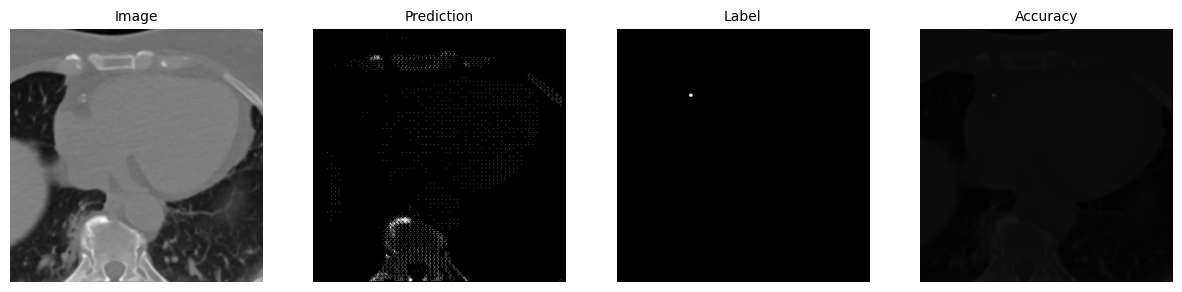

In [141]:
run_inference(342, th=99)

# Save Model

Create folder 


Models\\model_name\\

For Each Training
Models\\baseline_0\\baseline_0.pt

In [ ]:
if CFG.train_new:
    os.mkdir(f"Models/{CFG.model_name}")
    os.mkdir(f"Models/{CFG.model_name}/logs")

In [ ]:
# Save History as JSON
log_num = len(os.listdir(f"Models/{CFG.model_name}/logs"))
with open(f"Models/{CFG.model_name}/logs/log_{log_num}", "w") as out_path:
    json.dump(history, out_path)

TypeError: Object of type Tensor is not JSON serializable

In [ ]:
torch.save(model, f"Models/baseline/{CFG.model_name}.pt")

In [ ]:
CFG.model_name

'baseline_1'

# Notes

* Dropout
* Pixel Level Accuracy
* Single Conv in Block (Save Memory)
* Check Zoom
* 3D UNET